# Dimensionality Reduction. UMAP

## Introduction

This notebook is intended to be a gentle introduction into the topic of dimensionality reduction. This is a powerful technique used to **explore the structure of high-dimensional data (i.e. lots of features) in a lower dimensional subspace**.

For example, if a data set has 1000 dimensions/features, there is no way for us to visualise that data in 1000 dimenions because as humans we live and interact in a 3D world. However, we will see that there are ways to plot a meaningful representation of the data in 2 or 3 dimensions.


## UMAP

UMAP, which stands for **Uniform Manifold Approximation and Projection** was proposed by Leland McInnes, John Healy and James Melville in their 2018 paper: https://arxiv.org/abs/1802.03426

It learns a non-linear mapping that preserves clusters but its main advantage is that it is significantly faster that alternatives like t-SNE. It also tends to do better at preserving global structure of the data compared to t-SNE and PCA.

UMAP is designed to be compatible with scikit-learn, making use of the same API and able to be added to sklearn pipelines. If you are already familiar with sklearn you should be able to use UMAP as a drop in replacement for t-SNE and other dimension reduction classes

In [ ]:
#!pip install seaborn
#!pip install umap-learn

In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

# for better graphics:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

### Penguin dataset

<img src="https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/man/figures/lter_penguins.png" alt="penguins" style="width:400px"/>

The next step is to get some data to work with. To ease us into things we’ll start with the [penguin dataset](https://github.com/allisonhorst/palmerpenguins). It is small both in number of points and number of features, and will let us get an idea of what the dimension reduction is doing.

In [2]:
penguins = pd.read_csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins.csv")
penguins.head()

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  year  
0       3750.0    male  2007  
1       3800.0  female  2007  
2       3250.0  female  2007  
3          NaN     NaN  2007  
4       3450.0  female  2007

In [3]:
# remove NaN values
penguins = penguins.dropna()
penguins.species.value_counts()

Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64


<img src="https://github.com/allisonhorst/palmerpenguins/blob/c19a904462482430170bfe2c718775ddb7dbb885/man/figures/culmen_depth.png?raw=true
" alt="penguins" style="width:400px"/>


See the github repostiory for more details about the dataset itself. It consists of measurements of bill (culmen) and flippers and weights of three species of penguins, along with some other metadata about the penguins. In total we have 333 different penguins measured. Visualizing this data is a little bit tricky since we can’t plot in 4 dimensions easily. Fortunately four is not that large a number, so we can just to a pairwise feature scatterplot matrix to get an ideas of what is going on. Seaborn makes this easy.

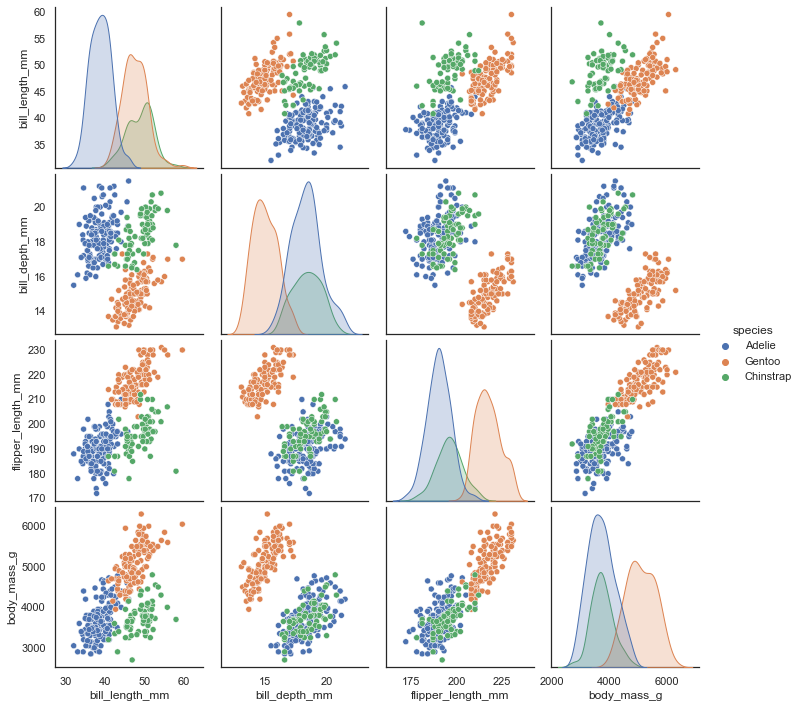

In [4]:
sns.pairplot(penguins.drop("year", axis=1), hue='species');

 ### What can a dimension reduction technique like UMAP do for us? 
 
 By reducing the dimension in a way that preserves as much of the structure of the data as possible we can get a visualisable representation of the data allowing us to “see” the data and its structure and begin to get some intuition about the data itself.

To use UMAP for this task we need to first construct a UMAP object that will do the job for us. That is as simple as instantiating the class. So let’s import the umap library and do that.

In [5]:
import umap

reducer = umap.UMAP()

Since the measurements are on entirely different scales it will be helpful to convert each feature to mean 0 and standard deviation 1. This is easy to do with sklearn’s StandardScaler.

In [6]:
penguin_data = penguins[
    [
        "bill_length_mm",
        "bill_depth_mm",
        "flipper_length_mm",
        "body_mass_g",
    ]
].values
scaled_penguin_data = StandardScaler().fit_transform(penguin_data)

Now we need to train our reducer, letting it learn about the manifold. For this UMAP follows the sklearn API and has a method `fit` which we pass the data we want the model to learn from. Since, at the end of the day, we are going to want to reduced representation of the data we will use, instead, the `fit_transform` method which first calls fit and then returns the transformed data as a numpy array.

In [8]:
embedding = reducer.fit_transform(scaled_penguin_data)
embedding.shape

(333, 2)

The result is an array with 333 samples, but only two feature columns (instead of the four we started with). This is because, by default, UMAP reduces down to 2D. Each row of the array is a 2-dimensional representation of the corresponding penguin

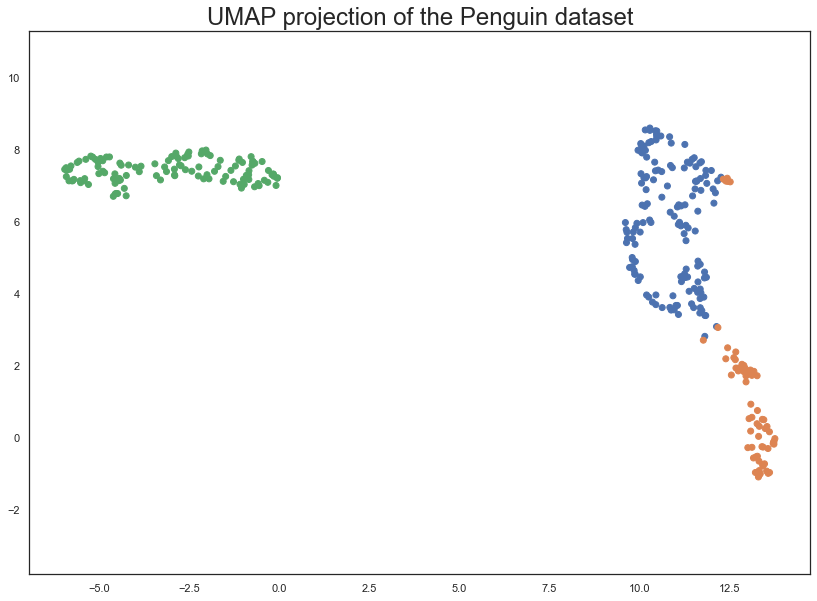

In [9]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in penguins.species.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Penguin dataset', fontsize=24);

This does a useful job of capturing the structure of the data, and as can be seen from the matrix of scatterplots this is relatively accurate. Of course we learned at least this much just from that matrix of scatterplots – which we could do since we only had four different dimensions to analyse. If we had data with a larger number of dimensions the scatterplot matrix would quickly become unwieldy to plot, and far harder to interpret. 

### Comparing UMAP to PCA

PCA is a linear dimension reduction technique. It works by finding the directions of maximum variance in the data, and then projecting the data onto a lower dimensional subspace formed by the principal components. This is a linear operation, and so PCA is only able to capture linear structure in the data. UMAP, on the other hand, is a non-linear dimension reduction technique. It is able to capture non-linear structure in the data, and so can often do a better job at preserving the global structure of the data.

Let's apply now PCA to the penguin dataset and compare the results with UMAP.

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca_penguins = pca.fit_transform(scaled_penguin_data)
pca_penguins.shape

(333, 2)

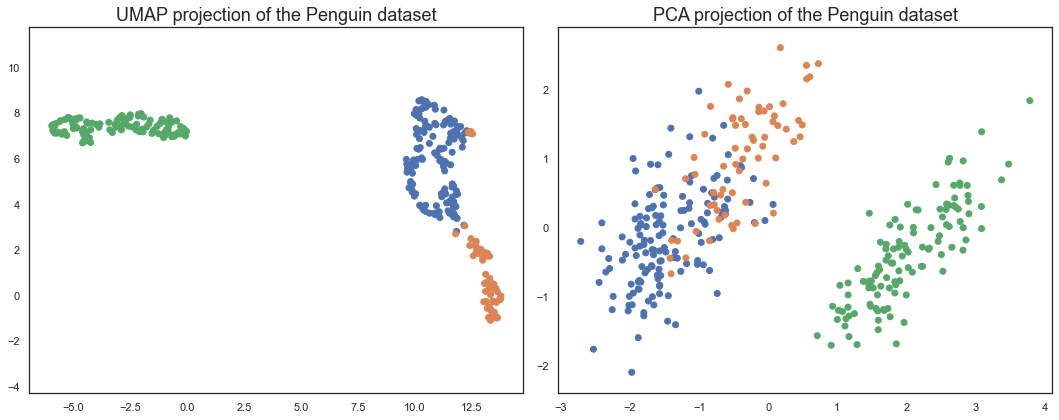

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# UMAP projection of the Penguin dataset
axs[0].scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in penguins.species.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
axs[0].set_aspect('equal', 'datalim')
axs[0].set_title('UMAP projection of the Penguin dataset', fontsize=18);

# PCA projection of the Penguin dataset
axs[1].scatter(
    pca_penguins[:, 0],
    pca_penguins[:, 1],
    c=[sns.color_palette()[x] for x in penguins.species.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
axs[1].set_aspect('equal', 'datalim')
axs[1].set_title('PCA projection of the Penguin dataset', fontsize=18);

plt.tight_layout()
plt.show()

We can see that UMAP does a better job at preserving the global structure of the data. The PCA plot is a bit more squashed, and the Adelie and Chinstrap penguins are not as well separated. This is because PCA is a linear dimension reduction technique, and so can only capture linear structure in the data. UMAP, on the other hand, is a non-linear dimension reduction technique.

Let's consider now a higher dimensional dataset, the previous digits data.

In [12]:
digits = load_digits()

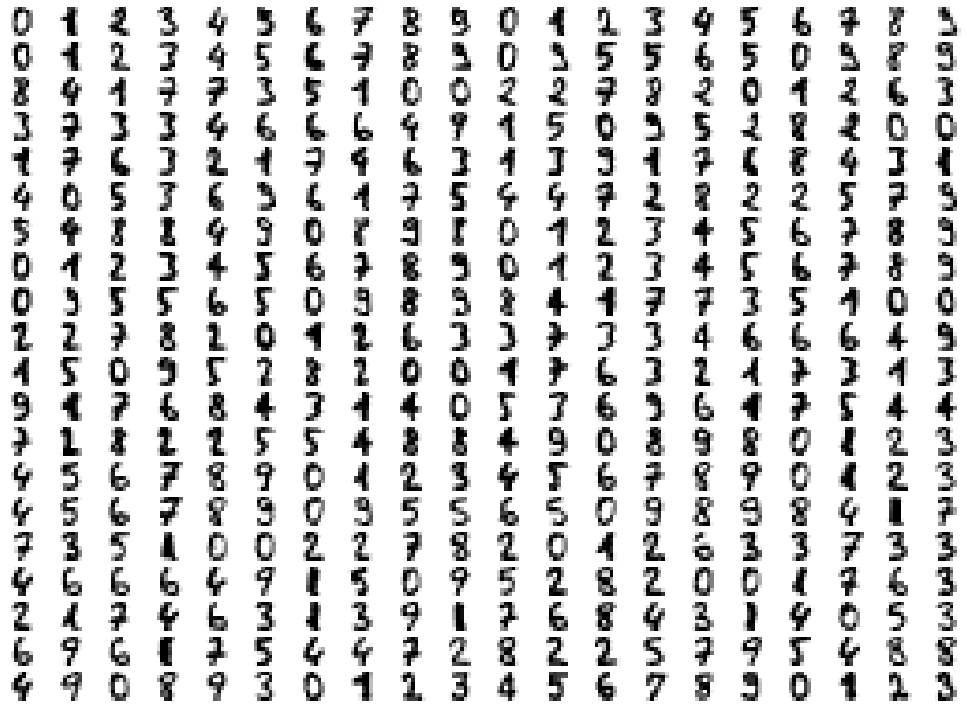

In [13]:
fig, ax_array = plt.subplots(20, 20)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray_r')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

We can try a scatterplot matrix – in this case just of the first 10 dimensions so that it is at least plottable, but as you can quickly see that approach is not going to be sufficient for this data.

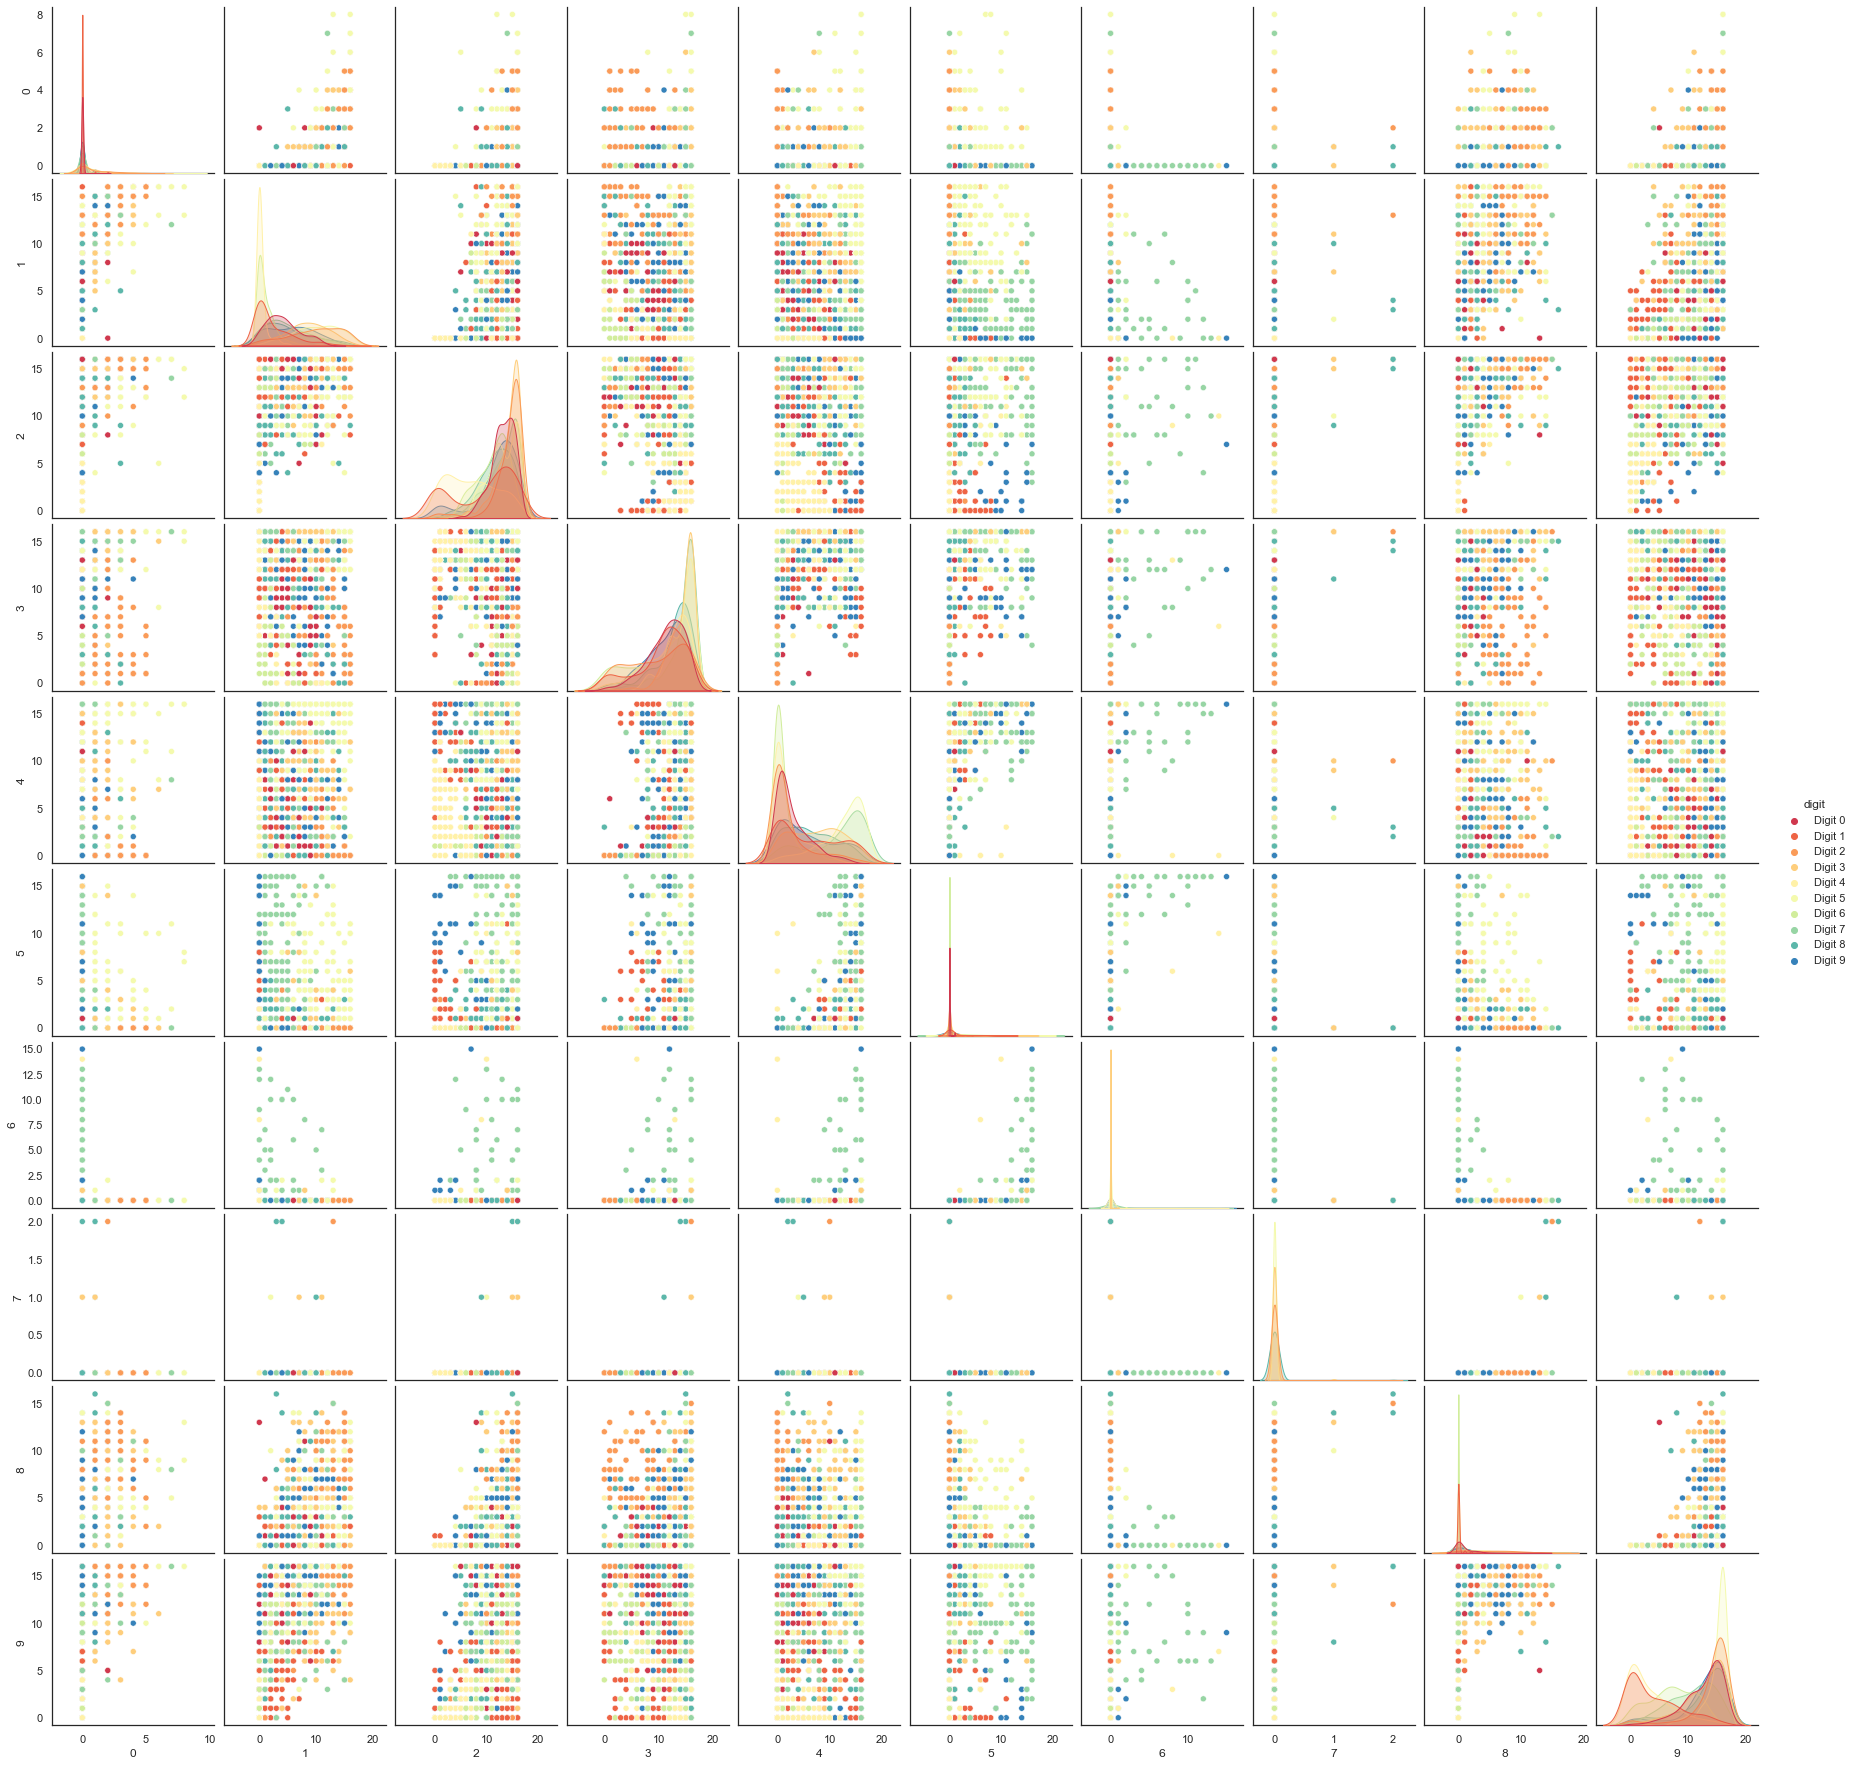

In [14]:
digits_df = pd.DataFrame(digits.data[:,1:11])
digits_df['digit'] = pd.Series(digits.target).map(lambda x: 'Digit {}'.format(x))
sns.pairplot(digits_df, hue='digit', palette='Spectral');

In contrast we can try using UMAP again.

In [15]:
reducer = umap.UMAP(random_state=0)
reducer.fit(digits.data)

/Users/victorgallego/miniforge3/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(random_state=0, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [16]:
embedding = reducer.transform(digits.data)
embedding.shape

(1797, 2)

We now have a dataset with 1797 rows (one for each hand-written digit sample), but only 2 columns. As with the Penguins example we can now plot the resulting embedding, coloring the data points by the class that they belong to (i.e. the digit they represent).

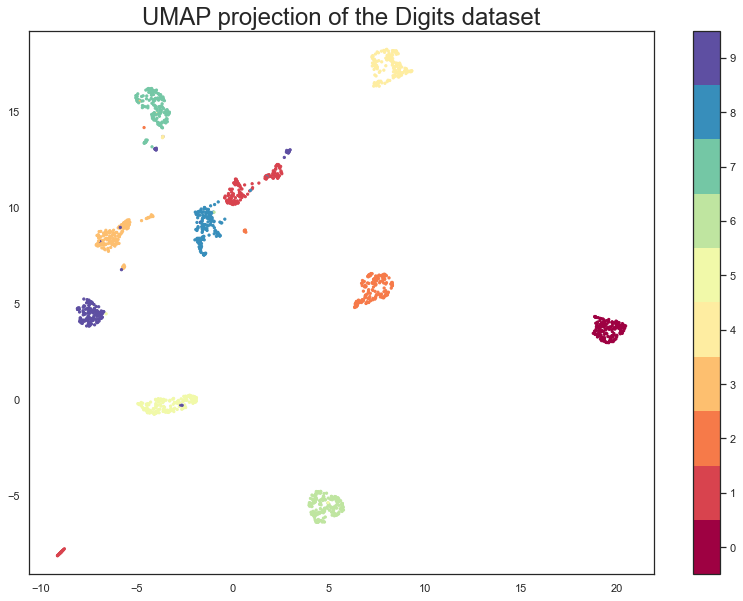

In [17]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

Let's compare, again, UMAP with PCA.

In [18]:
pca = PCA(n_components=2)

pca_digits = pca.fit_transform(digits.data)

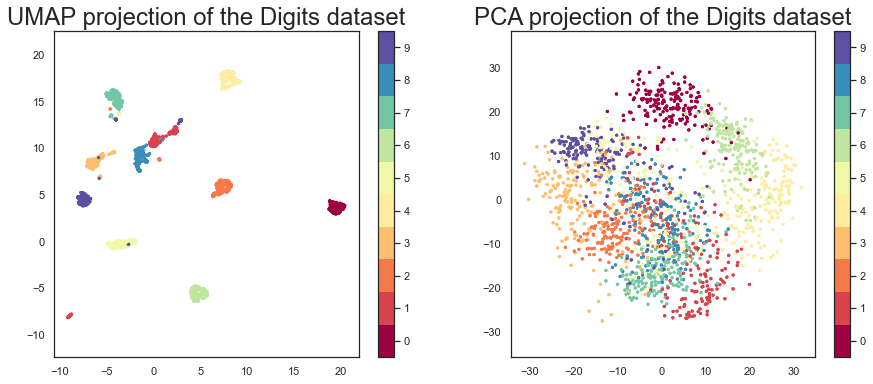

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# First plot
ax[0].scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
ax[0].set_aspect('equal', 'datalim')
fig.colorbar(ax[0].scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5), boundaries=np.arange(11)-0.5, ax=ax[0]).set_ticks(np.arange(10))
ax[0].set_title('UMAP projection of the Digits dataset', fontsize=24)

# Second plot
ax[1].scatter(pca_digits[:, 0], pca_digits[:, 1], c=digits.target, cmap='Spectral', s=5)
ax[1].set_aspect('equal', 'datalim')
fig.colorbar(ax[1].scatter(pca_digits[:, 0], pca_digits[:, 1], c=digits.target, cmap='Spectral', s=5), boundaries=np.arange(11)-0.5, ax=ax[1]).set_ticks(np.arange(10))
ax[1].set_title('PCA projection of the Digits dataset', fontsize=24)

plt.show()

### Interactive plots with UMAP

This is a useful way of checking specific samples of the dataset

In [ ]:
#!pip install umap-learn[plot]

First we’ll need to encode all the images for inclusion in a dataframe.

In [20]:
from io import BytesIO
from PIL import Image
import base64

def embeddable_image(data):
    img_data = 255 - 15 * data.astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.Resampling.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

Next we need to load up bokeh and the various tools from it that will be needed to generate a suitable interactive plot.

In [21]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10

output_notebook()

Loading BokehJS ...

Finally we generate the plot itself with a custom hover tooltip that embeds the image of the digit in question in it, along with the digit class that the digit is actually from (this can be useful for digits that are hard even for humans to classify correctly).

In [22]:
digits_df = pd.DataFrame(embedding, columns=('x', 'y'))
digits_df['digit'] = [str(x) for x in digits.target]
digits_df['image'] = list(map(embeddable_image, digits.images))

datasource = ColumnDataSource(digits_df)
color_mapping = CategoricalColorMapper(factors=[str(9 - x) for x in digits.target_names],
                                       palette=Spectral10)

plot_figure = figure(
    title='UMAP projection of the Digits dataset',
    width=600,
    height=600,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Digit:</span>
        <span style='font-size: 18px'>@digit</span>
    </div>
</div>
"""))

plot_figure.circle(
    'x',
    'y',
    source=datasource,
    color=dict(field='digit', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4
)
show(plot_figure)

## Hyperparameters in UMAP

The underlying reduction algorithm has many parameters that can significantly impact the manifold and hence, the visuals. The four most important ones are:

* `n_components`
* `n_neighbors`
* `min_dist`
* `metric`

As you might have guessed, `n_components` controls the number of dimensions after the projection. The default is 2 for its ease of visualization. However, for datasets with more than 100 features, 2D may not be enough to preserve the underlying topological structure of the data fully. I recommend trying values between 2-20 at steps of 5 and evaluate different baseline models to see the change in accuracy.

Next, we have `n_neighbors`. It controls the area of the local neighborhood UMAP looks at for each sample when building the manifold. Smaller values narrow the focus to local structure, taking into account peculiarities and small patterns, potentially losing the big picture.

Higher values to `n_neighbors` give more flexibility and allows UMAP to focus on a broader "view" of the data in the corresponding dimension. This, of course, comes at the cost of losing the finer details of the structure. The default value for this parameter is 15.

![image](images/n_neighbors.png)

Another critical parameter is `min_dist` which controls the literal distance between data points. You can tweak the default value of 0.1 to control the tightness of distinct point clouds. Lower values will result in clumpier embeddings, allowing you to see individual clusters more easily. This may be useful during clustering. In contrast, values close to 1 give points more breathing room and enable you to see the broader topological structure.

![image](images/min_dist.png)

### Further reading on UMAP

* Nice visualizations to explain UMAP, made by Google: https://pair-code.github.io/understanding-umap/